# Dataset

"Challenges in Representation Learning: A report on three machine learning
contests." I Goodfellow, D Erhan, PL Carrier, A Courville, M Mirza, B
Hamner, W Cukierski, Y Tang, DH Lee, Y Zhou, C Ramaiah, F Feng, R Li,
X Wang, D Athanasakis, J Shawe-Taylor, M Milakov, J Park, R Ionescu,
M Popescu, C Grozea, J Bergstra, J Xie, L Romaszko, B Xu, Z Chuang, and
Y. Bengio. arXiv 2013.

In [122]:
import pandas as pd
import numpy as np
import cv2
import os
import glob

In [123]:
emotions_lookup = {0 : "angry", 1 : "disgust", 2 : "fear", 3 : "happy", 4 : "sad", 5 : "surprise", 6 : "neutral"}

In [124]:
def csv_to_files(csv, dataset_name):
    emotions_lookup = {0 : "angry", 1 : "disgust", 2 : "fear", 3 : "happy", 4 : "sad", 5 : "surprise", 6 : "neutral"}
    # create different folders for images, by emotions
    curdir = os.getcwd()
    dirs = set(emotions_lookup.values())
    for dr in dirs:
        dest = os.path.join(curdir, str(dr))
        if not os.path.exists(dest):
            os.mkdir(dest)
    for index, row in csv.iterrows():
        pixels = np.asarray(list(row["pixels"].split(" ")), dtype = np.uint8).reshape((48, 48))
        destdir = os.path.join(emotions_lookup[row["emotion"]])
        filepath = os.path.join(destdir,f"{destdir}_{dataset_name}{index}.jpg")
        if not os.path.exists(filepath):
            #print(f"{filepath} is created")
            cv2.imwrite(filepath, pixels)
        else:
            #print("Error")
            exit(-1)

In [125]:
fer_data = pd.read_csv("fer2013.csv")
csv_to_files(fer_data, "fer")

In [126]:
data_size = {}
path_df = pd.DataFrame(columns = ["folder_name","image_name","emotion","label"])
for i in range(7):
    emotion = emotions_lookup[i]
    # Select all file paths of images tagged with emotion i
    emotionFiles = glob.glob(f"./{emotion}/*.jpg")
    # Populate data_size file to understand sample size
    data_size[emotion] = len(emotionFiles)
    # Append data paths to df
    folder_name = [file[0:(file.rfind("/")+1)] for file in emotionFiles]
    image_name = [str(file.split("/")[-1]) for file in emotionFiles]
    emotion_array = [[emotion]*len(emotionFiles)][0]
    label = [i]*len(emotionFiles)
    d = {"folder_name":folder_name, "image_name":image_name, "emotion":emotion_array, "label":label}
    temp_emotion_df = pd.DataFrame(data = d)
    path_df= path_df.append(temp_emotion_df, ignore_index = True)
data_size

{'angry': 4953,
 'disgust': 547,
 'fear': 5121,
 'happy': 8989,
 'sad': 6077,
 'surprise': 4002,
 'neutral': 6198}

In [127]:
path_df

,folder_name,image_name,emotion,label
0,./angry/,angry_fer35270.jpg,angry,0
1,./angry/,angry_fer33601.jpg,angry,0
2,./angry/,angry_fer12817.jpg,angry,0
3,./angry/,angry_fer7793.jpg,angry,0
4,./angry/,angry_fer18484.jpg,angry,0
...,...,...,...,...
35882,./neutral/,neutral_fer936.jpg,neutral,6
35883,./neutral/,neutral_fer10969.jpg,neutral,6
35884,./neutral/,neutral_fer17960.jpg,neutral,6
35885,./neutral/,neutral_fer29656.jpg,neutral,6


# Keras model

In [202]:
import sys, os
import cv2
from keras.applications import VGG16

In [204]:
# Convert emotion label to categorical matrix
emotions = pd.get_dummies(path_df["emotion"]).values

In [205]:
# Split data into training set and test set (85% training, 15% test)
x_train, x_test, y_train, y_test = train_test_split(path_df[["folder_name","image_name"]], emotions, train_size = 0.85, random_state = 42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((30503, 2), (5384, 2), (30503, 7), (5384, 7))

In [208]:
x_train = x_train.reset_index(drop= True)
x_test = x_test.reset_index(drop= True)

In [209]:
def load_images(image_df):
    images = []
    for i, row in image_df.iterrows():
        curdir = os.getcwd()
        path1 = row["folder_name"]                
        path2 = row["image_name"]              
        image = cv2.imread(os.path.join(curdir, path1, path2))
        images.append(image)
    return np.array(images)

x_train_images = load_images(x_train)
x_test_images = load_images(x_test)

In [210]:
x_train_images.shape, x_test_images.shape

((30503, 48, 48, 3), (5384, 48, 48, 3))

In [213]:
import pickle

pickle_out = open("x_train.pickle","wb")
pickle.dump(x_train_images, pickle_out)
pickle_out.close()

pickle_out = open("y_train.pickle","wb")
pickle.dump(y_train, pickle_out)
pickle_out.close()

pickle_out = open("x_test.pickle","wb")
pickle.dump(x_test_images, pickle_out)
pickle_out.close()

pickle_out = open("y_test.pickle","wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()

# to retrieve pickles
#pickle_in = open("x_train.pickle","rb")
#x_train = pickle.load(pickle_in)

# Test- What features do vgg-16 detect

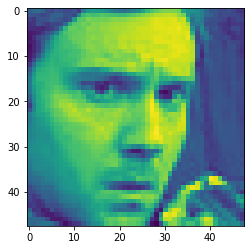

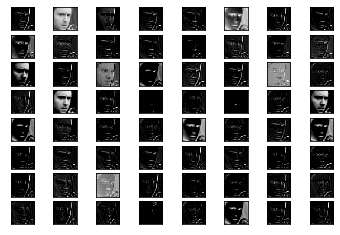

In [291]:
from keras.applications import vgg16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras import Input
import matplotlib.pyplot as plt

# display source photo
photo = plt.imread('angry_fer0.jpg')
plt.imshow(photo)
plt.show()

model = vgg16.VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[1].output)

img_path = 'angry_fer0.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = np.array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) # scale image pixels
feature_maps = model.predict(x)

# show features detected in first layer
square = 8
ix = 1
for i in range(square):
    for i in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
plt.show()

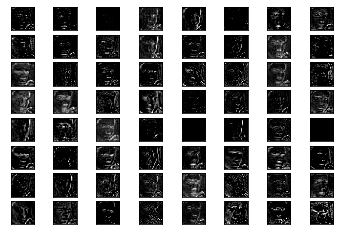

In [292]:
# features detected in a middle layer
model = vgg16.VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[7].output)

img_path = 'angry_fer0.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = np.array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) # scale image pixels
feature_maps = model.predict(x)

square = 8
ix = 1
for i in range(square):
    for i in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
plt.show()

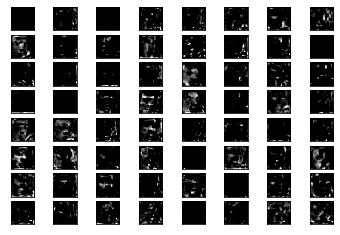

In [293]:
# features detected in final layer
model = vgg16.VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[12].output)

img_path = 'angry_fer0.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = np.array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) # scale image pixels
feature_maps = model.predict(x)

square = 8
ix = 1
for i in range(square):
    for i in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
plt.show()

# Extract and save features

In [254]:
from keras.applications import vgg16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model, Sequential
from keras import Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def extract_features(pickle_name):
    # retrieve pickles
    pickle_in = open(f"{pickle_name}.pickle","rb")
    file = pickle.load(pickle_in)

    model = vgg16.VGG16(weights='imagenet', include_top=False)
    features = []

    for i in range(len(file)):
        img = file[i]
        x = np.expand_dims(img, axis=0)
        x = preprocess_input(x) # scale image pixels
        feature = model.predict(x)
        features.append(feature)
        print(feature.shape)
    
    return np.array(features)

In [248]:
def pickle_out(pickle_name, data):
    pickle_out = open(f"{pickle_name}.pickle","wb")
    pickle.dump(data, pickle_out)
    pickle_out.close()

In [255]:
x_train_features = extract_features("x_train")
x_train_features.shape
pickle_out("x_train_features", x_train_features)

(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 512)
(1, 1, 1, 

KeyboardInterrupt: 

In [235]:
x_test_features = extract_features("x_test")
x_test_features.shape
pickle_out("x_test_features", x_test_features)

x_test.pickle


In [281]:
x_train.shape, x_train_features.shape, y_train.shape, x_train_features.shape[1:]

((30503, 2), (30503, 1, 1, 1, 512), (30503, 7), (1, 1, 1, 512))

In [282]:
num_features = 64
num_labels = 7

In [283]:


# Sequential Convolution Network for emotion clasification

model = Sequential()
     
model.add(Dense(512, activation='relu', input_shape = x_train_features.shape[1:]))
model.add(Dropout(0.1))
    
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
    
model.add(Dense(64, activation='relu'))
model.add(Dense(activation='softmax', units = num_labels)) 

model.summary()


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_82 (Dense)             (None, 1, 1, 1, 512)      262656    
_________________________________________________________________
dropout_18 (Dropout)         (None, 1, 1, 1, 512)      0         
_________________________________________________________________
dense_83 (Dense)             (None, 1, 1, 1, 256)      131328    
_________________________________________________________________
dense_84 (Dense)             (None, 1, 1, 1, 128)      32896     
_________________________________________________________________
batch_normalization_16 (Batc (None, 1, 1, 1, 128)      512       
_________________________________________________________________
dense_85 (Dense)             (None, 1, 1, 1, 64)       8256      
_________________________________________________________________
dense_86 (Dense)             (None, 1, 1, 1, 7)      

In [284]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from sklearn.metrics import accuracy_score

model_path = "./models/model.h5"
model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ["accuracy"])

# lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)

# early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')

# checkpointer = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True)

# model.fit(x_train_features, y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1,
#           validation_data=(x_test_features, y_test),
#           shuffle=True,
#           callbacks=[lr_reducer, TensorBoard, early_stopper, checkpointer])

model.fit(x_train_features, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test_features, y_test),
          shuffle=True)

ValueError: Error when checking target: expected dense_86 to have 5 dimensions, but got array with shape (30503, 7)

# Extract bottlenet features for training data
train_dummy_labels = pd.get_dummies(y_train).as_matrix()
train_dummy_labels.shape

def load_images(batch_size, image_df, label): #update to handle smaller batches
    global batch_index
    images = []
    labels = []
    dummy_labels = pd.get_dummies(label).as_matrix()
    size = image_df.shape[0]
    for i in range(batch_size):
        path1 = image_df.iloc[batch_index + i]["folder_name"]
        path2 = image_df.iloc[batch_index + i]["image_name"]
        image = cv2.imread(os.path.join(path1, path2))
        image = (image/ 255.0).astype(np.float)
        images.append(image)
        labels.append(dummy_labels[batch_index + i])
    
    batch_index += batch_size
    
    return np.array(images), np.array(labels)

def extract_features(image_df, label, output_dir, outputlabels_dir):
    model = VGG16(weights='imagenet', include_top=False, pooling = "Max")
    size = image_df.shape[0]
    batch_size = 10
    for i in range(int(size/batch_size)):
        x, y = load_images(batch_size, image_df, label)
        np.save(os.path.join(outputlabels_dir, "labels_{}".format(i+1)), y)
        features = model.predict(x)
        np.save(os.path.join(output_dir, "features_{}".format(i+1)), features)
        print(f"Features for batch {i + 1} created and saved\n")

def create_feature_directory(datatype):
    curdir = os.getcwd()   
    feature_dir = os.path.join(curdir, "data", f"{datatype}_features")
    labels_dir = os.path.join(curdir, "data", f"{datatype}_labels")
    if not os.path.exists(feature_dir):
        os.makedirs(feature_dir)
    if not os.path.exists(labels_dir):
        os.makedirs(labels_dir)
    return feature_dir, labels_dir

# Test with small batch
batch_index = 0
output_dir, outputlabels_dir = create_feature_directory("traintest")
extract_features(x_train.iloc[:20], y_train.iloc[:20], output_dir, outputlabels_dir)

curdir = os.getcwd()   
jpg_dir = os.path.join(curdir, "angry_fer0.jpg")
image = cv2.imread(jpg_dir)/255.0
model = VGG16(weights='imagenet', include_top=False)
features = model.predict(image)
features

# Test
curdir = os.getcwd()   
feature_dir = os.path.join(curdir, "data", "traintest_features","features_1.npy")
test = np.load(feature_dir)
test[0]

batch_index = 0
output_dir, outputlabels_dir = create_feature_directory("train")
extract_features(x_train, y_train, output_dir, outputlabels_dir)

batch_index = 0
output_dir, outputlabels_dir = create_feature_directory("test")
extract_features(x_test, y_test, output_dir, outputlabels_dir)

class_count =7

def model(input_shape):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_dim = input_shape))
    model.add(Dropout(0.1))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_dim = class_count, activation='softmax')) 
    return model

from keras.layers import Dropout, Dense
from keras.layers.normalization import BatchNormalization

#training the model
train_features_path = "../data/train_features/"
train_labels_path = "../data/train_labels"
train_features_path = "../data/test_features/"
train_labels_path = "../data/test_labels"
model_path = "../data/model/"

input_shape = 10*10*512   # Feature dimension is (10, 1, 1, 512)

model = model(input_shape)
model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ["accuracy"])

epochs = 20
batch_size = 10
step = 0
train_features_file_count = int(x_train.shape[0] / batch_size)
test_features_file_count = int(x_test.shape[0] / batch_size)
epoch_number, train_loss, train_acc, test_loss, test_acc = [], [], [], [], []

for epoch in range(epochs):
    avg_epoch_train_loss, avg_epoch_train_acc, avg_epoch_test_loss, avg_epoch_test_acc = 0, 0, 0, 0
    epoch_number.append(epoch + 1)
    for i in range(train_features_file_count):
        step += 1
        # Loading batch of training features to train MLP
        x_train_load = np.load(os.path.join(train_features_path, "features_{}.npy".format(i+1)))
        x_train = X_CombTrain_load.reshape(x_train_load.shape[0], x_train_load.shape[1]*x_train_load.shape[2]*x_train_load.shape[3])
        y_train = np.load(os.path.join(train_labels_path, "labels_{}.npy".format(i+1)))
        
        # Loading test data
        x_test_load = np.load(os.path.join(test_features_path, "features_{}.npy".format(i+1)))
        x_test = X_CombTrain_load.reshape(x_test_load.shape[0], x_test_load.shape[1]*x_test_load.shape[2]*x_test_load.shape[3])
        y_test = np.load(os.path.join(test_labels_path, "labels_{}.npy".format(i+1)))
        
        train_loss, train_accuracy = model.train_on_batch(x_train, y_train) #train the model on batch
        test_loss, test_accuracy = model.test_on_batch(x_test, y_test) #cross validate the model on CV Human batch
        #add epoch/loss tracking later

model.save(os.path.join(model_path, "model.h5"))